# Fermi's Golden Rule

### Imported Library


In [1]:
using Plots             # For plotting results
using LaTeXStrings      # For the utilisation of Latex in Plots
using LinearAlgebra     # For matrix computation
using SparseArrays      # For matrix computation with sparsity

using FermiGoldenRule

## The 1-site connected Chain Model

We study a quantum system on the hilbert space $\mathbb{C}\oplus\ell^2(\mathbb{Z})$ endowed described by the folowing Hamiltonian :
$$ H :=
\underbrace{\begin{pmatrix}
E & 0 \\
0 & A
\end{pmatrix}}_{H₀}  + 
\underbrace{ϵ\begin{pmatrix}
0 &  e_{R_0}^*\\
e_{R_0} & 0
\end{pmatrix}}_{H_\epsilon} $$
where $E$ is a complex, $A$ a matrix defined later, $R_0\in\mathbb{Z}$ and $(e_n)_{n\in\mathbb{Z}}$ is the canonical basis of  $\ell^2(\mathbb{Z})$ and $(e_n^*)_{n\in\mathbb{Z}}$ is its dual basis. A quantum state of $\mathbb{C}\oplus\ell^2(\mathbb{Z})$ is denoted by $\varphi = (z,ψ)$ with $z\in\mathbb{C}$ and $ψ\in\ell^2(\mathbb{Z})$. The parameter $ϵ$ represents the size of the perturbation represented by $H_\epsilon$.

In [2]:
# Modelisation of the Hamiltonian
A(N::Int) = SymTridiagonal(zeros(N), ones(N-1))

δ(R::Int, Nmin::Int, Nmax::Int) = [R==i ? 1 : 0 for i in Nmin:Nmax] #Nmin:Nmax

h(E::Real, ϵ::Real, R₀::Int, Nmax::Int, Nmin::Int) = (z::Number, ϕ::Vector) -> (E*z + ϵ * ϕ[-Nmin+1+R₀], ϵ*z*δ(R₀,Nmin, Nmax)+A(length(ϕ))*ϕ)

h (generic function with 1 method)

As the aim of this notebook is to demonstrate numerically the golden fermi rule, we start with an eigenvector living in $\mathbb{C}$ so any $\varphi = (e^{i\theta},0)$ with $θ ∈ [0,2\pi)$ suits, so let's choose $\varphi₀ = (1,0)$.

In [7]:
# Initial condition
z₀ = 1.0
ϕ₀fun = (z₀, (N::Int) -> 0)

(1.0, var"#13#14"())

For reason of symmetry and to maximise the time before the collision with the bound of the lattice, we set $R_0=0$.

In [8]:
const R₀ = 0

0

In [9]:
# Parameters for the approximation
Nmax = 25                   # Upper bound of the lattice
Nmin = - Nmax               # Lower bound of the lattice
Lattice = Nmin:Nmax         # Definition of the discrete lattice
Nₜ = 2500                    # Definition of the number of timestep
T = 25                      # Duration of the simulation
timeT = LinRange(0,T,Nₜ+1)   # Time Lattice

# Initial condition on the lattiche
ϕ₀ = [ϕ₀fun[1], ϕ₀fun[2].(Lattice)...]
nothing

In [10]:
E = 0
ϵ = 0.1

dynamics(h(E, ϵ, R₀, Nmax, Nmin), ϕ₀fun, (Nmax = Nmax, Nmin = Nmin); T = 4, Nₜ = 1000)

MethodError: MethodError: no method matching dynamics(::var"#11#12"{Int64, Float64, Int64, Int64, Int64}, ::Tuple{Float64, var"#13#14"}, ::@NamedTuple{Nmax::Int64, Nmin::Int64}; T::Int64, Nₜ::Int64)

Closest candidates are:
  dynamics(::Union{Function, Type}, ::Tuple, !Matched::Tuple; T, Nₜ)
   @ FermiGoldenRule C:\Users\theoz\Documents\Document Théo\GitHub\Julia\FermiGoldenRule\Code\src\dynamics.jl:6


## Simulation of the model

In [ ]:
info = (Nmax = Nₓ_Array[end], Nmin = -Nₓ_Array[end])
animation(plot_simu, sol_Nₓ[end]; trace =  true, d = 10, info = info)

## Study of the spectrum of the discretized pertubated hamiltonian

In this section, we analyse the spectrum of H according to the value of $\epsilon$ and make the compareason between the spectrum in the infinite dimension case with the finite dimensional approximate hamiltonian.

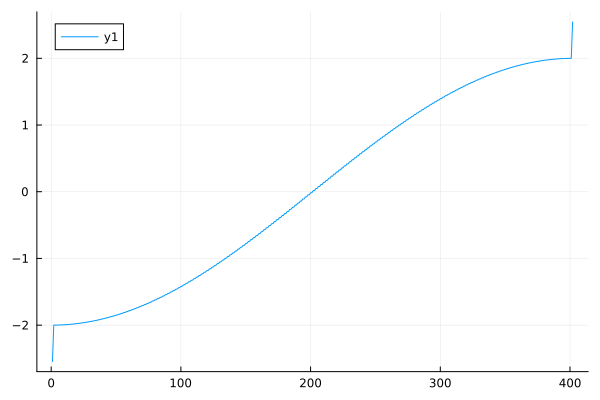

In [15]:
Nmax = 200
Nmin = -200
H = Ham_to_Matrix(h(0,2,R₀,Nmax,Nmin), Nmax, Nmin)
λ = eigen(H).values
plot(λ, mk = :x)

## Fermi Golden Rule

In this section, we verify the Golden-Fermi Rule numerically.

First we set the paramters.

In [71]:
# Numerical Parameters 
Nmax = 50                   # Upper bound of the lattice
Nmin = - Nmax               # Lower bound of the lattice
Lattice = Nmin:Nmax         # Definition of the discrete lattice
Nₜ = 2500                    # Definition of the number of timestep
T = 50                      # Duration of the simulation
timeT = LinRange(0,T,Nₜ+1)   # Time Lattice

# Initial condition on the lattice
ϕ₀ = [ϕ₀fun[1], ϕ₀fun[2].(Lattice)...]
print("Parameters settled!")

Then we compute the dynamics for different of the eigenvalue $E$ for a fixed amplitude of the pertubation $\epsilon$.

In [72]:
# Computation of the dynamics for different E and fixed ϵ
ϵ = 0.5
ArrayE = 0.0:0.5:4.0

ArrayEsol= [dynamics(h(E,ϵ,R₀,Nmax,-Nmax), ϕ₀fun; Nmax = Nmax, Nₜ = Nₜ, T = T) for E in ArrayE]
print("Dynamics computed !")

An now we can plot the results :

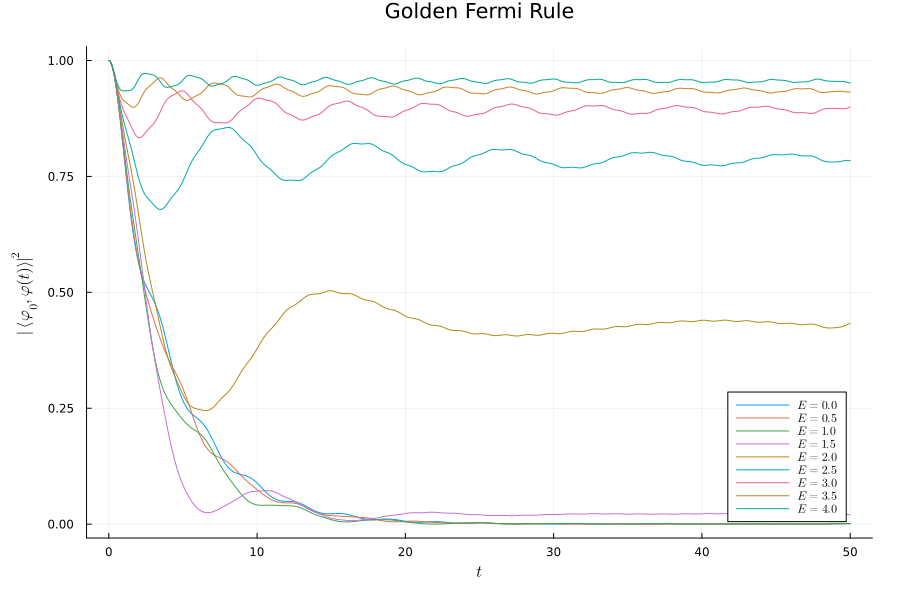

In [73]:
probaE = [proba(ϕ₀,sol) for sol in ArrayEsol]

plt = plot(size = (900,600), margin = 0.5Plots.cm)
for (proba,E) in zip(probaE, ArrayE)
    plot!(plt, timeT,proba, label = latexstring("E = ",E),legend = :bottomright)
end
xlabel!(L"t")
ylabel!(L"|⟨ϕ_0,ϕ(t)⟩|^2")
title!("Golden Fermi Rule")

In [67]:
using Optim

Sol = ArrayEsol[1]

loss(Γ, sol, time) = norm(sqeuclidean(proba(ϕ₀,sol),exp.(-Γ[1].*time*ϵ^2)))^2

Γ₀ = 1.0

#loss(Γ₀, Sol, timeT)
opt = optimize(Γ -> loss(Γ, Sol, timeT), [Γ₀]; iterations=100)
res = Optim.minimizer(opt)

1-element Vector{Float64}:
 1.0045742034912113

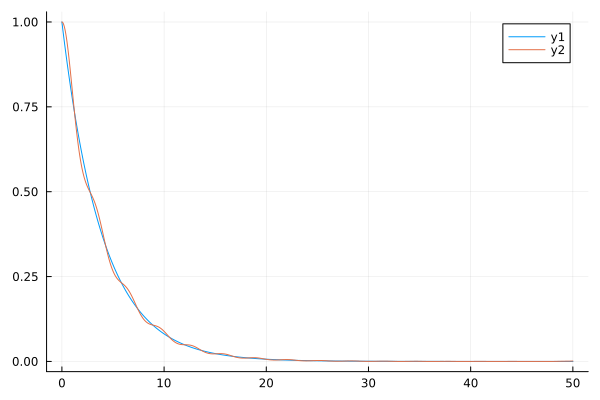

In [70]:
plot(timeT, exp.(-res.*timeT*ϵ^2))
plot!(timeT, proba(ϕ₀,Sol) )

### Study of the Livsic matrix




In [29]:
Livsic(E::Real, R₀::Int, Nmax::Int, Nmin::Int) = (z,ϵ) -> E .- ϵ^2 * δ(R₀,Nmin, Nmax)' * (A(Nmax - Nmin + 1) .- z)^(-1) * δ(R₀,Nmin, Nmax)

B = Livsic(2,0,5,-5)

#48 (generic function with 1 method)

In [32]:
#(A(length(Nmax + Nmin + 1)) .- im)^(-1) * δ(R₀,Nmin, Nmax)

size(δ(R₀,Nmin, Nmax))
size(A(Nmax - Nmin + 1))

g(z,ϵ)= B(z,ϵ) - z

g (generic function with 1 method)

In [34]:
using Roots 

find_zero(z->g(z,1), 2.1)

SingularException: SingularException(11)

In [36]:
using Plots
using Images, ImageTransformations

function perfract(x, t, m=0.7, M=1)
    x = x / t
    return m + (M-m) * (x-floor(x))
end 

function domcol(w; n=10)
    logm = log.(abs.(w)) # for lines of constant modulus
    H = angle.(w)*180/π #compute argument of  w within interval [-180, 180], iei the Hue

    V = perfract.(logm, 2π/n) # lines of constant log-modulus
    arr = permutedims(cat(H, ones(size(H)), V, dims=3), [3,1,2]) #HSV-array

    return RGB.(colorview(HSV, arr[:, end:-1:1,:]))
end

f = z->z^2*tan(z)
x = -5π/4:0.005:5π/4
y = -2.5:0.005:2.5
w = [f(u+1im*v) for v in y, u in x]
img = domcol(w; n=13)
imgn = imresize(img, ratio=1/4)

gr()
plot(x, y, imgn, xlims=(-3,2.2), ylims=(-1.5,2.5))

UndefVarError: UndefVarError: `colorview` not defined